# Understanding and plotting the decay of operonic and non-operonic gene pairs as a function of phylogenetic distance
The idea is to compute a genetic distance between two species. This will be used in comparing the genomic FGOC 
score between two species. <br />
I am using a tree computed (from the living tree of life) and downloaded from [silva DB](http://www.arb-silva.de/projects/living-tree/). This contains a curated list of 16sRNA and 23sRNA from bacterial and archael species. The tree nodes have been collapsed to the species level. This means I will have to use the same distance metric when comparing it at a strain level. <br />
The metric for the distance between two species is going to be a patristic distance. I calculate the distance matrix from this tree. The computation is intensive and requires a lot of memory. The file used is calcGenetic.py. I performed this calculation in a different server and stored it as a massive flatfile in the format - BACTERIA-A BACTERIA-B distance <br />

I then calculate the gene order conservation score comparing operonic genes and not operonic genes as a function of phylogenetic distance <br />
pkl files generated are - 
<ol><li> eco_org2_dist.dict.pkl </li>
<li> bsu_org2_dist.dict.pkl </li>
<li> bsu_allBact.notOperonScores.dict.pkl </li>
<li> bsu_allBact.operonScores.dict.pkl </li>
<li> eco_allBact.notOperonScores.dict.pkl </li>
<li> eco_allBact.operonScores.dict.pkl </li>
</ol>

In [2]:
import os
import pickle 

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

cogPair_dict = loadPkl('cogPair_count.dict.pkl')
cog_locusTag_dict = loadPkl('cog_locusTag.dict.pkl')
locus_cog_dict = loadPkl('locus_cog.dict.pkl')
org_cogPair_dict = loadPkl('org_cogPair.dict.pkl')
print "Dictionaries loaded"

Dictionaries loaded


In [22]:
# DICTIONARY FOR PATRISTIC DISTANCE
# Making a dictionary for (Org1,org2):dist where Org1 is either Escherichia or Bacillus etc.
import os
import cPickle as pickle

def savePkl(db,pklFname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'    
    f = os.path.join(pklDir,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

bactTreeDir = '/home/jaggu/research/downloads/bacterialTrees/silvaDB'
distFile = 'all.bactDist.txt'
fname = os.path.join(bactTreeDir,distFile)
#org = 'eco'
#orgName = 'Escherichia coli'
org = 'bsu'
orgName = 'Bacillus subtilis'
orgDistDict = dict()

with open(fname) as f:
    for line in f:
        if not line.startswith('BACTERIA'):
            if line.startswith(orgName):
                newLine = line.replace(' ','_')
                org1,org2,dist = newLine.strip().split('\t')
                dist = float(dist)
                org1Name = org1.split('_')[0]+'_'+org1.split('_')[1]
                org2Name = org2.split('_')[0]+'_'+org2.split('_')[1]
                #print org1Name, org2Name, dist
                orgDistDict[org2Name]=dist
savePkl(orgDistDict,org+'_org2_dist.dict.pkl')
print org + " : Pickled"


bsuPickled


In [43]:
# Calculating genFGOC score by comparing gene pair between operonic genes and non-operonic genes. 

import os
import cPickle as pickle

operondbDir = '/home/jaggu/research/downloads/operons_databases/microbesOnline'
sourceDir = '/home/jaggu/research/allGenomePttFiles'



def getOrientation(orgPttFile):
    #Get orientation right
    ifile = open(orgPttFile,'r')
    lines = ifile.readlines()
    ifile.close()
    orientationDict = dict()

    for line in lines[3:]:
        orientation,lTag = line.split('\t')[1],line.split('\t')[5]
        orientationDict[lTag]=orientation
    return orientationDict

def getCog(lTag):
    try:
        cog = locus_cog_dict[lTag]
    except KeyError:
        cog = 'nan'
    if cog == '-': cog = 'nan' #Some wierd bug
    return cog

def getCOGpairInfo(lTag1,lTag2):
    cogA = getCog(lTag1)
    cogB = getCog(lTag2)
    if cogA is 'nan' or cogB is 'nan':
        return None
    else:
        # Check orientation
        orientationA = orientationDict[lTag1]
        orientationB = orientationDict[lTag2]
        if orientationA == orientationB == '+':
            cogPair = (cogA,cogB)
        elif orientationA == orientationB == '-':
            cogPair = (cogB,cogA)
        else:
            cogPair = (cogA,cogB)
        return cogPair

# THIS IS WHERE YOU SHOULD CHANGE THE organism 
#org = 'eco' 
#orgName = ('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913')
#org = 'bsu'
#orgName = ('Bacillus_subtilis_168_uid57675', 'NC_000964')
    
wOp_COG_list = list()
bwOp_COG_list = list()
  
def makeOperonPairs(org,orgName):
    orgDir = os.path.join(sourceDir,orgName[0])
    orgPttFile = os.path.join(orgDir,orgName[1]+'.ptt') 
    # Getting orientation for each locus tag
    orientationDict = getOrientation(orgPttFile)

    # Parsing operon file
    fname = org+'.'+'operon'
    ifile = open(os.path.join(operondbDir,fname))
    lines = ifile.readlines()
    ifile.close()

    for line in lines[1:]:
        lTag1,lTag2,bOp = [line.split('\t')[i] for i in [2,3,6]]
        cogPair = getCOGpairInfo(lTag1,lTag2)

        if cogPair:
            if bOp == 'TRUE':
                wOp_COG_list.append(cogPair)
            else:
                bwOp_COG_list.append(cogPair)
    print "For organism : %s ; Operon list done (in COG)"%(org)
    return wOp_COG_list, bwOp_COG_list

eco_wOpPairs, eco_bwOpPairs = makeOperonPairs('eco',('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913'))
#bsu_wOpPairs, bsu_bwOpPairs = makeOperonPairs('bsu',('Bacillus_subtilis_168_uid57675', 'NC_000964'))


For organism : eco ; Operon list done (in COG)


In [181]:
# Parse through the cogPairs across orgs and ask for intersection of sets; Calculates the operon score and  
# not operon score

from __future__ import division
import fnmatch
import cPickle as pickle
import collections


def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and
    below supplied root directory.'''
    allFiles = []
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            allFiles.append(os.path.join(path,filename))
    return allFiles

def intersect(a,b):
    return list(set(a)&set(b))

def getPairs_list(cogPair_list):
    pair_list = list()
    for pair in cogPair_list:
        if not (pair[0] == '-' or pair[1] == '-'):
            pair_list.append(pair)
    if len(pair_list)>1: return pair_list
    else: return list()

def getOrgName(pttFile):
    accNbr = os.path.split(pttFile)[-1].split('.')[0]
    orgName = os.path.split(os.path.split(pttFile)[0])[1]
    return (orgName,accNbr)

def getScores(orgName):
    flag = True
    cogPair_list = org_cogPair_dict[orgName]
    pair_list = getPairs_list(cogPair_list)
    if pair_list:flag = True
    else: flag = False
    org_opList = intersect(pair_list,wOp_COG_list)
    org_notOpList = intersect(pair_list,bwOp_COG_list)

    operonScore = len(org_opList)/len(wOp_COG_list)
    notOperonScore = len(org_notOpList)/len(bwOp_COG_list)
    
    return operonScore,notOperonScore,flag
    

def savePkl(db,pklFname):
    f = os.path.join(pklPath,pklFname)
    pickle.dump(db,open(f,'w'))
    return 


pklPath = '/home/jaggu/research/projectFiles/operons/pklFiles'
sourceDir = '/home/jaggu/research/allGenomePttFiles'

allOperonScore_dict = collections.defaultdict(list)
allNotOperonScore_dict = collections.defaultdict(list)


def main():
    # Generating the operonScore and notOperonScore with all bacterial species
    print "Comparing %s with all bacteria ..."%(org)
    allPttFiles = locate('*.ptt',sourceDir)
    for pttFile in allPttFiles:
        #print "Parsing :  %s file ..."%(pttFile)
        compareOrg = getOrgName(pttFile)
        operonScore, notOperonScore,status = getScores(compareOrg) 
        #status variable makes sure there is atleast one gene assigned.         
        if status: 
            allOperonScore_dict[compareOrg[0]].append(operonScore)
            allNotOperonScore_dict[compareOrg[0]].append(notOperonScore)

    fOp = org + '_allBact.operonScores.dict.pkl'
    fNotOp = org + '_allBact.notOperonScores.dict.pkl'
    savePkl(allOperonScore_dict,fOp)
    savePkl(allNotOperonScore_dict,fNotOp)
    print "Operon and not operon Scores pickled"

        
def test_case():
    #org = ('Escherichia_coli_K_12_substr__MG1655_uid57779','NC_000913')
    #org = ('Bacillus_subtilis_168_uid57675', 'NC_000964')
    #org = ('Clostridium_perfringens_SM101_uid58117', 'NC_008264')
    org = ('Sphaerochaeta_pleomorpha_Grapes_uid82365','NC_016633')
    operonScore,notOperonScore,status = getScores(org)
    
    print org, operonScore, notOperonScore, status

#test_case()
main()


Comparing bsu with all bacteria ...
Operon and not operon Scores pickled


In [229]:
# Plotting the graph of Operon scores vs genetic distance

#org = 'eco'
org = 'bsu'

fDist = org + '_org2_dist.dict.pkl'
fOp = org + '_allBact.operonScores.dict.pkl'
fNotOp = org + '_allBact.notOperonScores.dict.pkl'
org_dist_dict = loadPkl(fDist)
allOperonScore_dict = loadPkl(fOp)
allNotOperonScore_dict = loadPkl(fNotOp)

opScore_dist_list = list()
notOpScore_dist_list = list()

for orgName, operonScore in allOperonScore_dict.items():
    species = orgName.split('_')[0]+'_'+orgName.split('_')[1]
    notOperonScore = allNotOperonScore_dict[orgName]
    try:
        dist = org_dist_dict[species]
    except KeyError:
        continue;
    opScore_dist_list.append([max(operonScore),dist])
    notOpScore_dist_list.append([max(notOperonScore),dist])

print "For %s : List of [operonScore,distance] and [notOperonScore, distance] calculated"%(org)


For bsu : List of [operonScore,distance] and [notOperonScore, distance] calculated


Organism : bsu ...


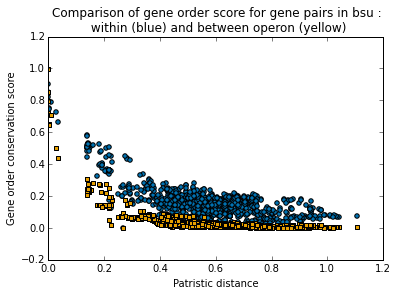

In [232]:
# Scatter plot between operon score and patristic distance
imgDir = '/home/jaggu/research/projectFiles/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

print "Organism : %s ..."%(org) #Carrying over
# For operon
op_yVals = [item[0] for item in opScore_dist_list]
op_dist = [item[1] for item in opScore_dist_list]

notOp_yVals = [item[0] for item in notOpScore_dist_list]
notOp_dist = [item[1] for item in notOpScore_dist_list]


plt.scatter(op_dist,op_yVals,c='#0072b2',marker='o')
plt.scatter(notOp_dist,notOp_yVals,c='#e69f00',marker='s')
plt.xlim(xmin=0,xmax=1.2)
plt.xlabel('Patristic distance')
plt.ylabel('Gene order conservation score')
plt.title('Comparison of gene order score for gene pairs in %s : \n within (blue) and between operon (yellow)'%(org))
#plt.show()

# Saving figure
fname = org+'_OpBw_dist.scatter.svg'
f = os.path.join(imgDir,fname)
plt.savefig(f,dpi=300)


***
# Distant COG pairs arising in the bacterial lineage 
<body> It is not exactly oldest. But I want to ask, for the COG pair present in E.coli operon, which is the most distant bacteria where it is also found. A time line is a proxy with patristic distance </body>



In [70]:
# Importing from 3rd cell for COG pairs within and between operons. Checking for E.coli first

import collections
import time
import os
import cPickle as pickle

def savePkl(db,pklFname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'    
    f = os.path.join(pklDir,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

#org_dist_cogPairs_dict = collections.defaultdict(list)
org_cogPair_allDist_dict = collections.defaultdict(list)

print "Total number of Ecoli operonic pairs ",len(eco_wOpPairs)
print len(org_cogPair_dict.keys())

eco_org2_dist_dict = loadPkl('eco_org2_dist.dict.pkl')

for opPair in eco_wOpPairs:
#    print "Checking ",opPair
    for org,cogPairList in org_cogPair_dict.items():
        orgName, accNbr = org
        species = orgName.split('_')[0]+'_'+orgName.split('_')[1]
        try: 
            dist = eco_org2_dist_dict[species]
        except KeyError:
            continue;
        if opPair in cogPairList:
            org_cogPair_allDist_dict[opPair].append(dist)
            #print species, dist
            
savePkl(org_cogPair_allDist_dict,'eco_opPair_allDist.dict.pkl')
print "Completed at ",time.ctime()


Total number of Ecoli operonic pairs  1422
2658
Completed at  Mon Nov 16 18:19:32 2015


In [72]:
import collections

org_cogPair_allDist_dict = loadPkl('eco_opPair_allDist.dict.pkl')

dist_cogPairs_dict = collections.defaultdict(list)
# Max distance for the COGPairs

for cogPair, distL in org_cogPair_allDist_dict.items():
    dist_cogPairs_dict[round(max(distL),2)].append(cogPair)

print "Distance : List of CogPairs dictionary created "

Distance : List of CogPairs dictionary created 


/home/jaggu/research/projectFiles/operons/figures/eco_OpPairs_dist_occurrance.bar.svg


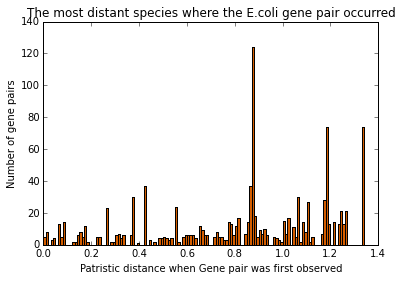

In [77]:
imgDir = '/home/jaggu/research/projectFiles/operons/figures'

% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

xyList = list()

for d in np.arange(0,1.5,0.01):
    try:
        cogPairs = dist_cogPairs_dict[d]
    except KeyError:
        cogPairs = []
    xyList.append((d,len(cogPairs)))
xList, yList = zip(*xyList)


rects = plt.bar(xList, yList, width=0.01, color='#D55E00')

plt.xlim([0,1.4])
plt.xlabel('Patristic distance when Gene pair was first observed')
plt.ylabel('Number of gene pairs')
plt.title('The most distant species where the E.coli gene pair occurred')

# Saving figure
fname = 'eco_OpPairs_dist_occurrance.bar.svg'
f = os.path.join(imgDir,fname)
print f
plt.savefig(f,dpi=300)

#plt.show()

In [82]:
# Details of the most common and distant COG pair
cog_func_dict = loadPkl('cogFunc.dict.pkl')

for dist, cogPairL in dist_cogPairs_dict.items():
    if dist > 1.3:
        for cogA,cogB in cogPairL: 
            print cogA, cogB, cog_func_dict[cogA][1],cog_func_dict[cogB][1]

COG4948 COG4948 L-alanine-DL-glutamate epimerase or related enzyme of enolase superfamily L-alanine-DL-glutamate epimerase or related enzyme of enolase superfamily
COG1173 COG0444 ABC-type dipeptide/oligopeptide/nickel transport system, permease component ABC-type dipeptide/oligopeptide/nickel transport system, ATPase component
COG0444 COG4608 ABC-type dipeptide/oligopeptide/nickel transport system, ATPase component ABC-type oligopeptide transport system, ATPase component
COG0094 COG0199 Ribosomal protein L5 Ribosomal protein S14
COG1175 COG3833 ABC-type sugar transport system, permease component ABC-type maltose transport system, permease component
COG0747 COG0601 ABC-type transport system, periplasmic component ABC-type dipeptide/oligopeptide/nickel transport system, permease component
COG0091 COG0092 Ribosomal protein L22 Ribosomal protein S3
COG0226 COG0573 ABC-type phosphate transport system, periplasmic component ABC-type phosphate transport system, permease component
COG0713 COG